# Team15_Project1

This is the deliverable ipynb file for BIOINF 575 Bioinformatics project assignment.

Team 15 members: John Larson, Henry Li, Ziyan Xu

Project topic: Drug Annotation of 23andme Report

## Input Data

`23andme_v5_hg19_ref.txt.gz` - retrieved at [23andme2vcf](https://github.com/arrogantrobot/23andme2vcf)

`var_drug_ann.tsv` - retrieved at [ClinPGx](https://www.clinpgx.org/downloads) (previously PharmGKB) as variantAnnotations.zip

the file was extracted and brought to the repository root directory for ease of access

## Imports, Functions, and Translations

In [2]:
import gzip

In [3]:
def getfp(filename):
	"""Returns a file pointer for reading based on file name"""
	if filename.endswith('.gz'):
		return gzip.open(filename, 'rt', encoding='utf-8')
	else:
		return open(filename, 'r', encoding='utf-8')


def is_valid_allele(allele_entry):
	"""Checks if allele entry is valid"""
	allele_entry = allele_entry.strip().upper()
	if not allele_entry: # empty string
		return False
	if any(x in allele_entry for x in ["A", "C", "G", "T", "DEL", "/", "+"]):
		return True
	return False


def to_tsv(data_dict, filename, sep="\t", columns=None):
	"""Writes a dictionary of dictionaries to a TSV file."""
	with open(filename, 'w') as fp:
		# write header
		if columns:
			fp.write(sep.join(columns) + "\n")
		else:
			# no header, write all keys from the dictionary values
			fp.write(sep.join(next(iter(data_dict.values())).keys()) + "\n")

		# write rows
		for entry in data_dict.values():
			if columns:
				row = [entry.get(col, "") for col in columns]
			else:
				row = list(entry.values())
			fp.write(sep.join(row) + "\n")

In [4]:
char_trans_table = str.maketrans({
	'"': '',        # remove quotes
	' ': ' ',       # U+00a0 - regular space
	' ': ' ',       # U+2009 - regular space
	' ': ' ',       # U+202F - regular space
	' ': ' ',       # U+2003 - regular space
	' ': ' ',       # U+2005 - regular space
	'–': '-',       # U+2013 - regular hyphen
})

## Task 1

**Map/merge** the 23andme file and the variant-drug annotation file based on dbSNP_ID (aka rsID).

The merged result should have the following columns:

```
dbSNP_ID, GENE_SYMBOL, DRUG_NAME, PMID, PHENOTYPE_CATEGORY, SIGNIFICANCE, NOTES, SENTENCE, ALLELE_PharmGKB (variant alleles in annotation), ALLELE_23andme (variant alleles in 23andme file)
```

In [5]:
# read PharmGKB variant drug annotation file
ann_entries = {}  # entryID -> {entry_info dict}

with getfp('var_drug_ann.tsv') as fp:
	# get wanted column names
	oldcols = fp.readline().strip().split('\t')[1:10]
	oldcols = [i.upper() for i in oldcols]
	cols = []

	# new column names
	for col in oldcols:
		if col == 'VARIANT/HAPLOTYPES':
			col = 'dbSNP_ID'
		elif col == 'GENE':
			col = 'GENE_SYMBOL'
		elif col == 'DRUG(S)':
			col = 'DRUG_NAME'
		elif col == 'ALLELES':
			col = 'ALLELE_PharmGKB'
		if ' ' in col:
			col = col.replace(' ', '_')
		cols.append(col)

	# parse entries
	for line in fp:
		original_fields = line.strip().split('\t')

		# remove bad characters and unwanted quotes in fields
		fields = [
			i.translate(char_trans_table) for i in original_fields
		]

		# check second column for rsID presence
		if "rs" not in fields[1]:
			continue  # skip non-rsID entries

		# check allele validity
		if not is_valid_allele(fields[9]):
			continue  # skip invalid allele entries

		entryID = fields[0]

		entry_info = {}
		for i, col in enumerate(cols):
			entry_info[col] = fields[i + 1]  # offset by 1

		ann_entries[entryID] = entry_info  # entryID -> {entry_info dict}

print(len(ann_entries))

9830


In [6]:
# read 23andMe v5 file
snp_entries = {} # rsID -> allele

with getfp('23andMe_v5_hg19_ref.txt.gz') as fp:
	for line in fp:
		fields = line.strip().split('\t')
		rsID = fields[2]

		# check for rsID presence
		if "rs" not in rsID:
			continue

		snp_entries[rsID] = fields[3] # rsID -> allele

print(len(snp_entries))

620634


In [7]:
# merge results by rsID
merged_entries = {} # entryID -> {entry_info dict + ALLELE_23andme: allele}

for entryID, entry_info in ann_entries.items():
	dbSNP_ID = entry_info.get('dbSNP_ID')
	if dbSNP_ID in snp_entries:
		# entryID -> {entry_info dict + ALLELE_23andme: allele}
		# entryID -> {merged_info dict}
		merged_entries[entryID] = {**entry_info, 'ALLELE_23andme': snp_entries[dbSNP_ID]}

print(len(merged_entries))

6111


## Task 2

**Filter** the output so that it only contains significant associations (**SIGNIFICANCE** is **yes**) for variants that affect the drug efficacy (**PHENOTYPE_CATEGORY** is **efficacy**).

In [8]:
# filter for SIGNIFICANCE == 'yes' and PHENOTYPE_CATEGORY is 'efficacy'
filtered_entries = {} # entryID -> {filtered_info dict}
for entryID, merged_info in merged_entries.items():
	if merged_info.get('SIGNIFICANCE').lower() == 'yes' and merged_info.get('PHENOTYPE_CATEGORY').lower() == 'efficacy':
		filtered_entries[entryID] = merged_info

print(len(filtered_entries))

1434


## Task 3

**Save** the output of the filtering step in a tab-separated file (**23andme_PharmGKB_map.tsv**) with the following columns:

```
dbSNP_ID, GENE_SYMBOL, DRUG_NAME, NOTES, SENTENCE, ALLELE_PharmGKB, ALLELE_23andme
```

In [9]:
# save the output in tsv file
output_cols = [
	"dbSNP_ID", "GENE_SYMBOL", "DRUG_NAME",
	"NOTES", "SENTENCE", "ALLELE_PharmGKB", "ALLELE_23andme"
]

to_tsv(
	filtered_entries,
	"23andme_PharmGKB_map.tsv",
	sep="\t",
	columns=output_cols
)

print("File saved as 23andme_PharmGKB_map.tsv")

File saved as 23andme_PharmGKB_map.tsv


## Task 4

**Create** a tab separated file (**23andme_PharmGKB_summary.tsv**) with summarized data with the following columns:

```
GENE_SYMBOL, DRUG_NAME, dbSNP_IDs (list of IDs separated by ";")
```

In [10]:
import pandas as pd

# Load the merged TSV from Task 1
df = pd.read_csv("23andme_PharmGKB_map.tsv", sep="\t")

# Keep only the required columns
df_subset = df[["GENE_SYMBOL", "DRUG_NAME", "dbSNP_ID"]].dropna()

# Step 1: Create an empty list to store summarized rows
summary_rows = []

# Step 2: Group the dataframe by gene and drug
for (gene, drug), group in df_subset.groupby(["GENE_SYMBOL", "DRUG_NAME"]):
    # Get all unique dbSNP_IDs for this gene–drug pair
    snps = sorted(set(group["dbSNP_ID"]))
    
    # Join them into a single string
    snp_list = ";".join(snps)
    
    # Append a dictionary (one row of output)
    summary_rows.append({
        "GENE_SYMBOL": gene,
        "DRUG_NAME": drug,
        "dbSNP_IDs": snp_list
    })

# Step 3: Convert that list of dicts back into a DataFrame
summary_df = pd.DataFrame(summary_rows)


# Save summarized output to new TSV
summary_df.to_csv("23andme_PharmGKB_summary.tsv", sep="\t", index=False)

print("Summary file created: 23andme_PharmGKB_summary.tsv")
print(summary_df.head())


Summary file created: 23andme_PharmGKB_summary.tsv
  GENE_SYMBOL                                DRUG_NAME            dbSNP_IDs
0       ABCA1  atorvastatin, rosuvastatin, simvastatin            rs2230806
1       ABCA1                              fenofibrate  rs2230806;rs2230808
2       ABCB1                          antidepressants            rs1128503
3       ABCB1                           antipsychotics            rs1128503
4       ABCB1                            carbamazepine            rs1128503


## Task 5

**Plot** the distribution (histogram) of the number of drugs associated with a gene, and the number of SNPs for a gene.

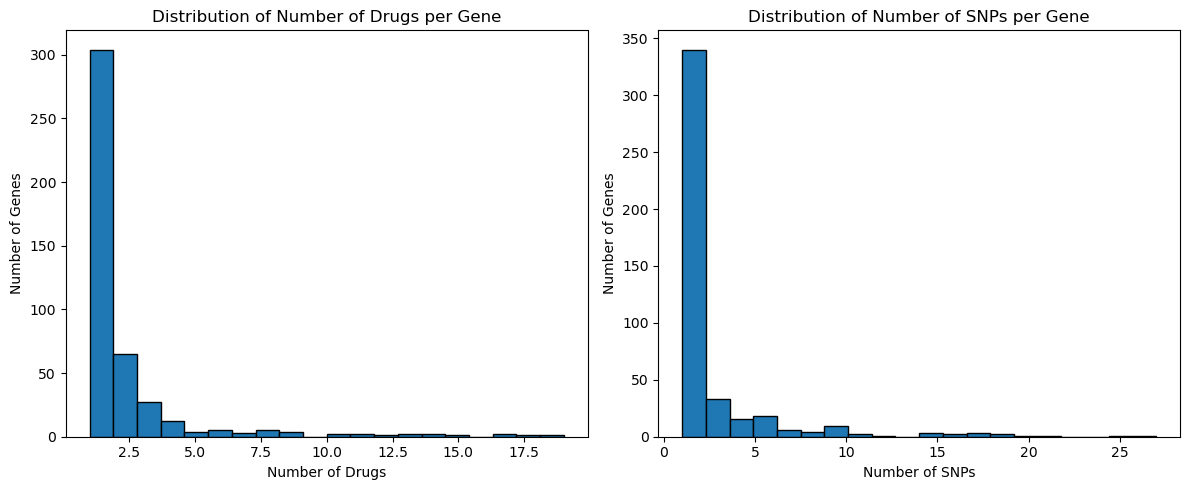

In [12]:

import matplotlib.pyplot as plt
# 1) Number of drugs per gene
drugs_per_gene = (
    summary_df.groupby("GENE_SYMBOL")["DRUG_NAME"]
    .nunique()
    .reset_index(name="num_drugs")
)

# 2) Number of SNPs per gene
#    First, count SNPs in each gene–drug row, then sum across a gene
snp_counts = (
    summary_df.assign(num_snps=summary_df["dbSNP_IDs"].apply(lambda x: len(str(x).split(";"))))
    .groupby("GENE_SYMBOL")["num_snps"]
    .sum()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 5))

# Plot 1 - number of drugs associated with a gene
plt.subplot(1, 2, 1)
plt.hist(drugs_per_gene["num_drugs"], bins=20, edgecolor="black")
plt.title("Distribution of Number of Drugs per Gene")
plt.xlabel("Number of Drugs")
plt.ylabel("Number of Genes")

# Plot 2 - number of SNPs associated with a gene
plt.subplot(1, 2, 2)
plt.hist(snp_counts["num_snps"], bins=20, edgecolor="black")
plt.title("Distribution of Number of SNPs per Gene")
plt.xlabel("Number of SNPs")
plt.ylabel("Number of Genes")

plt.tight_layout()
plt.show()


## Task 6

As a team decide on a new feature for each of the team members to implement. These new features should be included in the solution and should answer a relevant biological question using the data available for the project. New data can be used for the implementation of these new features.

In [6]:
# John's New Feature

In [7]:
# Henry's New Feature

In [8]:
# Ziyan's New Feature